In [8]:
# %% Import Libraries
#This is a test
import os
import pickle
import scipy.io
import numpy as np
import pandas as pd
import torch as tc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import ruptures as rpt
from scipy.stats import zscore

import matplotlib.patches as mpatches
from tqdm import tqdm
from bptt.models import Model
import model_anafunctions as func


plt.rcParams['font.size'] = 20

   CP_data  CP_behaviour  Trial_distance  CP_id
0       30            30               0      1
1       70            70               0      2
2      130           130               0      3
3      170           170               0      4
4      215           170              45      5


Text(0, 0.5, 'Neuronal Change Point')

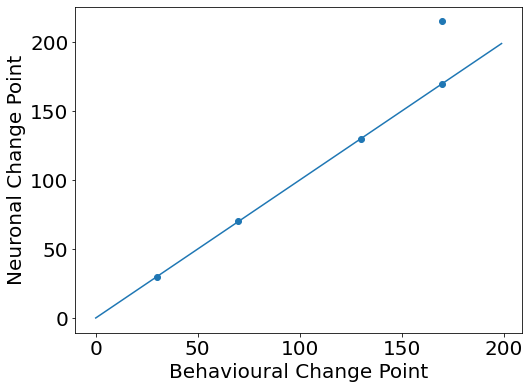

In [9]:
# Loading Data: Full Session
data_path = 'D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\bptt_DM01_7\\neuralactivity\\datasets' 
ses_n,ses_i = func.load_data(data_path,'FullSession')
full_n,_ = func.concatenate_list(ses_n,0)
full_i,_ = func.concatenate_list(ses_i,0)

# Loading Data: Behaviour
path_beh='D:/_work_cestarellas/Analysis/PLRNN/Session_Selected/OFC/DM01_7_220524'
ll=3

os.chdir(path_beh)
list_files = os.listdir(path_beh)

for i in list_files:
    if i.find('Behaviour')>0:
        Behaviour_name = i

# Load data
# Open the Behaviour file
Bdata = scipy.io.loadmat(Behaviour_name)
BehData = Bdata[list(Bdata.keys())[-1]]
# Classification of trials following the behabiour
GambleRewardTrials = np.where((BehData[:,12]==1) & (BehData[:,13]==1))[0]
GambleNoRewardTrials =  np.where((BehData[:,12]==1) & (BehData[:,13]==0))[0]
SafeRewardTrials = np.where((BehData[:,12]==0) & (BehData[:,13]==1))[0]
SafeNoRewardTrials = np.where((BehData[:,12]==0) & (BehData[:,13]==0))[0]
NoRespondingTrials = np.where(BehData[:,10]==1)[0]


# Blocks
Block_Prob = np.unique(BehData[:,5])
BlockTrials = [np.where(Block_Prob[i]==BehData[:,5])[0][0] for i in range(len(Block_Prob))]
# Smoothing the data for plotting
ScaleDecision=BehData[:,12]+(BehData[:,12]-1)
SigmaDecision=1
Binx =0.5
KernelWindow = np.arange(-3*SigmaDecision, 3*SigmaDecision, Binx)
KernelDecision = np.exp(-(KernelWindow/SigmaDecision)**2/2)
DecisionConvolution=np.convolve(ScaleDecision,KernelDecision,mode='same')
DecisionNormalized=(DecisionConvolution/np.nanmax(np.abs(DecisionConvolution))+1)/2

if NoRespondingTrials[0]<20:
    first_trial = NoRespondingTrials[0]+1
    last_trial = NoRespondingTrials[1]-1
else:
    first_trial = 0
    last_trial = NoRespondingTrials[ll]-1

if np.isnan(DecisionNormalized).any():
    # Find indices of valid values and their corresponding values
    valid_indices = np.where(~np.isnan(DecisionNormalized))[0]
    valid_values = DecisionNormalized[valid_indices]

    # Generate indices to interpolate (including NaNs)
    interpolate_indices = np.arange(len(DecisionNormalized))

    # Interpolate NaN values
    interpolated_values = np.interp(interpolate_indices, valid_indices, valid_values)
    BD = interpolated_values[0:last_trial]
else:
    BD=DecisionNormalized[0:last_trial]


# Computing change points from behaviour performance: Gamble Choice probability (BD)
model_ch = rpt.Pelt(model="rbf",min_size=5)
model_ch.fit(BD)
result_ch = model_ch.predict(pen=5)

# Preparing data for change points detection version 1:

# Temporal sectors: Period of time selected to compute the mean firing rate
TrialTime_ini = np.where(np.diff(full_i[:,0])==1)[0]-49                         # Initial point: Beginning trial
TrialTime_end = np.append(TrialTime_ini[1:],full_i.shape[0])                    # Final point: Ending trial
# Determining number of trials and number of neurons
num_trials = len(TrialTime_end)
num_neurons = full_n.shape[1]
X_data = np.zeros((num_trials,num_neurons))                                     # Initial matrix of mean firing rate of each neuron (columns), and trials (rows)
for it in range(num_trials):
    X_data[it,:]=np.mean(full_n[TrialTime_ini[it]:TrialTime_end[it],:],0)


MUA = X_data.mean(1)                                                            # Mean value of the firing rate
algo = rpt.Dynp(model="rbf", min_size=10)
algo.fit(X_data)
opt_bk = 5              
result_mua = algo.predict(n_bkps=opt_bk)


k_bkpt = 0
cp_data = []
distance = []
cp_behaviour = []
cp_id = []
for bkp in result_mua[:-1]:
        dist_cp = [np.abs(bkp-i) for i in result_ch[:-1]]
        dist_mua = np.array(dist_cp)

        trial_distance = dist_mua.min()
        cp_pos = np.argmin(dist_mua)
        cp_data.append(bkp)
        cp_behaviour.append(result_ch[cp_pos])
        distance.append(trial_distance)
        k_bkpt +=1
        cp_id.append(k_bkpt)

CP_info = {"CP_data":cp_data,
        "CP_behaviour":cp_behaviour,
        "Trial_distance":distance,
        "CP_id":cp_id}
CP_df = pd.DataFrame(CP_info)
print(CP_df)

plt.figure(figsize=(8,6))
plt.scatter(CP_df["CP_behaviour"],CP_df["CP_data"])
plt.plot(range(200),range(200))
plt.xlabel("Behavioural Change Point")
plt.ylabel("Neuronal Change Point")


In [ ]:
# #%% Data Organization
# General Directories
path_models = 'D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\' # For models and Training and Test data
path_behaviours = 'D:\\_work_cestarellas\\Analysis\\PLRNN\\Session_Selected\\OFC'        # For behavioural sessions

#Model
mod_sessions = os.listdir(path_models)
extra_models = 'results\\DataTrainingH768_lm1_1e-05_lm2_128_lm3_00_seql_400\\001'
#Neuronal Activity
extra_activity = 'neuralactivity\\datasets\\'
#Behaviour
rec_sessions = os.listdir(path_behaviours)

#################### WARNING
# Be careful!!! Check if the order of mod_sessions and rec_sessions is the same
#################### WARNING